### Importing required libraries

In [1]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1654033367861_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Installing required libraries into current PySpark Session

In [3]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("boto3==1.23.10")
sc.install_pypi_package("tabulate==0.8.9")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…







You are using pip version 9.0.1, however version 22.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 22.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 22.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 22.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 22.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 22.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [113]:
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Reading in data from an s3 bucket

In [13]:
import boto3
import io
import pandas as pd

s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket('pranathi-sentiment')



object_key = 'final_classification.csv'
bucket_name = 'pranathi-sentiment'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

df = pd.read_csv(io.StringIO(csv_string))
print(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          class         date
0       neutral  2021-05-24 
1       neutral  2021-05-24 
2      positive  2021-05-24 
3      negative  2021-05-24 
4       neutral  2021-05-24 
...         ...          ...
10523   neutral  2022-05-28 
10524   neutral  2022-05-28 
10525   neutral  2022-05-28 
10526   neutral  2022-05-28 
10527   neutral  2022-05-28 

[10528 rows x 2 columns]

### Defining function to transform the categorical data (class-- which is the sentiment)

In [11]:
def transform(x):
    if x =='neutral':
        return 0
    elif x=='positive':
        return 1
    else:
        return -1
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
df['class'] = df['class'].apply(transform)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Calculating the average sentiment of posts per day

In [25]:
final_df = df.groupby('date').mean()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
final_df.reset_index(inplace = True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Reading in Historical S&P index data from an s3 bucket (for the same timeline as the scraped posts)

In [35]:
import boto3
import io

s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket('pranathi-sentiment')



object_key = 'Historical_S&p.csv'
bucket_name = 'pranathi-sentiment'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

df_1 = pd.read_csv(io.StringIO(csv_string))
df_1['change'] = (df_1['Close/Last'] - df_1['Open'])/df_1['Open']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Converting date formats to enable merging of different data sources

In [36]:
import time
#df['conv_date'] = df['Date'].apply(lambda x: time.strftime("%Y-%m-%d ", time.gmtime(x)))
df_1['Date'] = pd.to_datetime(df_1['Date']).dt.strftime('%Y-%m-%d ') 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
df_1.rename(columns = {'Date':'date'}, inplace = True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
final_corr_df = pd.merge(final_df, df_1, how = 'inner', on = 'date')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Calculating correlation between S&P index performance and the average sentiment of posts per day

In [57]:
from scipy.stats.stats import pearsonr

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
pearsonr(final_corr_df['class'], final_corr_df['change'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.04793912185422197, 0.4532354205763967)

In [114]:
close = np.linalg.norm(final_corr_df['Close/Last'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [115]:
close

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

69652.71768474435

In [60]:
pearsonr(final_corr_df['class'], final_corr_df['Close/Last'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.14591615902992838, 0.021795617685811758)

### Plotting the average sentiment of posts per day, and the change in the opening and closing performance of the S&P index per day

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

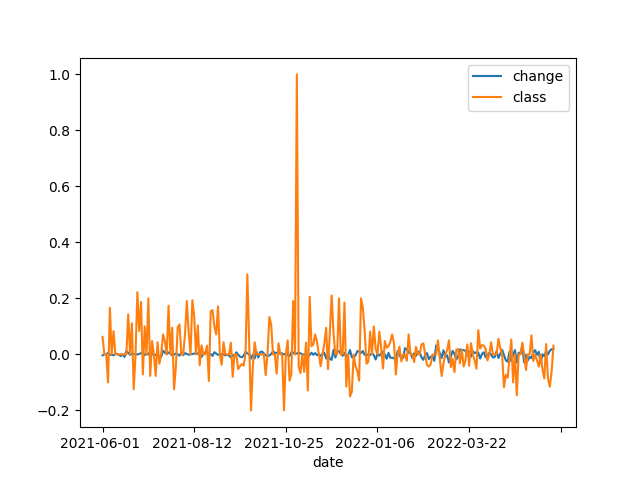

NameError: name 'final_corr_df' is not defined

In [100]:
%matplot plt
final_corr_df.plot(x = 'date', y = ['change', 'class'], kind = 'line')
plt.show()